Assignment #1

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [3]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified .\notMNIST_large.tar.gz
Found and verified .\notMNIST_small.tar.gz


In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

.\notMNIST_large already present - Skipping extraction of .\notMNIST_large.tar.gz.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
.\notMNIST_small already present - Skipping extraction of .\notMNIST_small.tar.gz.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


In [32]:
images = []
from random import randint
for dir_name, dirs, files in os.walk('.\\notMNIST_large'):
    if len(files) > 0:
        img_path = dir_name+'\\'+files[randint(0, len(files)-1)]
        images.append(img_path)
for image in images:
    display(Image(filename=image))

In [33]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling .\notMNIST_large\A.pickle.
.\notMNIST_large\A


Could not read: .\notMNIST_large\A\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file '.\\notMNIST_large\\A\\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.


Could not read: .\notMNIST_large\A\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file '.\\notMNIST_large\\A\\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.


Could not read: .\notMNIST_large\A\Um9tYW5hIEJvbGQucGZi.png : cannot identify image file '.\\notMNIST_large\\A\\Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.


Full dataset tensor: (52909, 28, 28)
Mean: -0.12825


Standard deviation: 

0.443121
Pickling .\notMNIST_large\B.pickle.
.\notMNIST_large\B


Could not read: .\notMNIST_large\B\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file '.\\notMNIST_large\\B\\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.


Full dataset tensor: (52911, 28, 28)
Mean: -0.00756303


Standard deviation: 0.454491


Pickling .\notMNIST_large\C.pickle.
.\notMNIST_large\C


Full dataset tensor: (52912, 28, 28)
Mean: -0.142258


Standard deviation: 0.439806


Pickling .\notMNIST_large\D.pickle.
.\notMNIST_large\D


Could not read: .\notMNIST_large\D\VHJhbnNpdCBCb2xkLnR0Zg==.png : cannot identify image file '.\\notMNIST_large\\D\\VHJhbnNpdCBCb2xkLnR0Zg==.png' - it's ok, skipping.


Full dataset tensor: (52911, 28, 28)
Mean: -0.0573678


Standard deviation: 0.455648


Pickling .\notMNIST_large\E.pickle.
.\notMNIST_large\E


Full dataset tensor: (52912, 28, 28)
Mean: -0.069899


Standard deviation: 

0.452942
Pickling .\notMNIST_large\F.pickle.
.\notMNIST_large\F


Full dataset tensor: (52912, 28, 28)
Mean: -0.125583


Standard deviation: 0.44709


Pickling .\notMNIST_large\G.pickle.


.\notMNIST_large\G


Full dataset tensor: (52912, 28, 28)
Mean: -0.0945814


Standard deviation: 

0.44624
Pickling .\notMNIST_large\H.pickle.


.\notMNIST_large\H


Full dataset tensor: (52912, 28, 28)
Mean: -0.0685221


Standard deviation: 0.454232


Pickling .\notMNIST_large\I.pickle.


.\notMNIST_large\I


Full dataset tensor: (52912, 28, 28)
Mean: 0.0307862


Standard deviation: 

0.468899
Pickling .\notMNIST_large\J.pickle.


.\notMNIST_large\J


Full dataset tensor: (52911, 28, 28)
Mean: -0.153358


Standard deviation: 0.443656


Pickling .\notMNIST_small\A.pickle.
.\notMNIST_small\A


Could not read: .\notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png : cannot identify image file '.\\notMNIST_small\\A\\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png' - it's ok, skipping.


Full dataset tensor: (1872, 28, 28)
Mean: -0.132626
Standard deviation: 0.445128
Pickling .\notMNIST_small\B.pickle.
.\notMNIST_small\B

Full dataset tensor: (1873, 28, 28)
Mean: 0.00535609
Standard deviation: 0.457115
Pickling .\notMNIST_small\C.pickle.
.\notMNIST_small\C


Full dataset tensor: (1873, 28, 28)
Mean: -0.141521
Standard deviation: 0.44269
Pickling .\notMNIST_small\D.pickle.
.\notMNIST_small\D


Full dataset tensor: (1873, 28, 28)
Mean: -0.0492167
Standard deviation: 0.459759
Pickling .\notMNIST_small\E.pickle.
.\notMNIST_small\E


Full dataset tensor: (1873, 28, 28)
Mean: -0.0599148
Standard deviation: 0.45735
Pickling .\notMNIST_small\F.pickle.


.\notMNIST_small\F


Could not read: .\notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png : cannot identify image file '.\\notMNIST_small\\F\\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png' - it's ok, skipping.


Full dataset tensor: (1872, 28, 28)
Mean: -0.118185
Standard deviation: 0.452279
Pickling .\notMNIST_small\G.pickle.
.\notMNIST_small\G


Full dataset tensor: (1872, 28, 28)
Mean: -0.0925503
Standard deviation: 0.449006
Pickling .\notMNIST_small\H.pickle.
.\notMNIST_small\H


Full dataset tensor: (1872, 28, 28)
Mean: -0.0586893
Standard deviation: 0.458759
Pickling .\notMNIST_small\I.pickle.
.\notMNIST_small\I


Full dataset tensor: (1872, 28, 28)
Mean: 0.0526451
Standard deviation: 0.471894
Pickling .\notMNIST_small\J.pickle.


.\notMNIST_small\J


Full dataset tensor: (1872, 28, 28)
Mean: -0.151689
Standard deviation: 0.448014


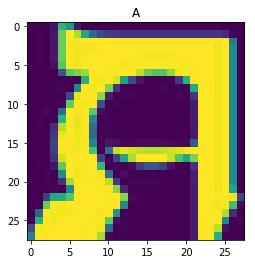

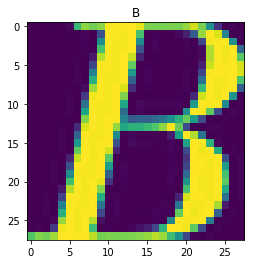

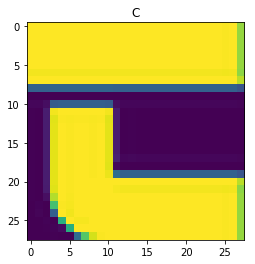

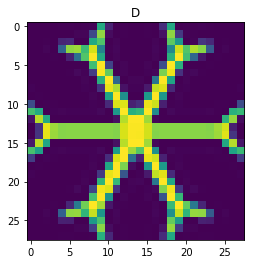

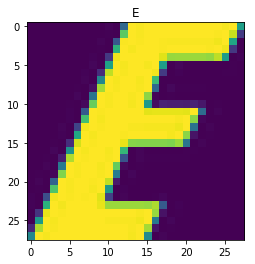

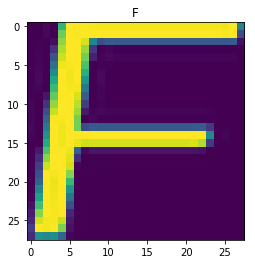

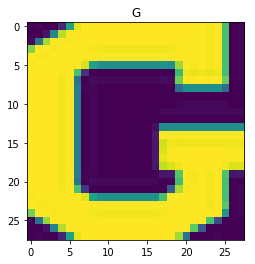

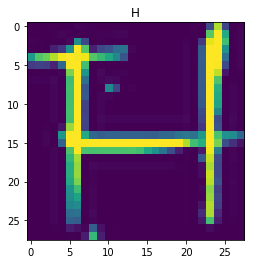

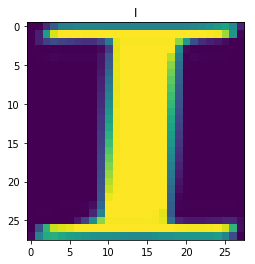

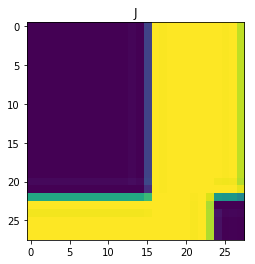

In [57]:
for train_dataset in train_datasets:
    with open(train_dataset, "rb") as f:
        dataset = pickle.load(f)
        image = dataset[randint(0, len(dataset)-1), :, :] * 255 + 127.5
        plt.title(os.path.splitext(os.path.basename(os.path.normpath(train_dataset)))[0])
        plt.imshow(image)
        plt.show()

In [64]:
number_of_images = []
for train_dataset in train_datasets:
    with open(train_dataset, "rb") as f:
        dataset = pickle.load(f)
        title = os.path.splitext(os.path.basename(os.path.normpath(train_dataset)))[0]
        print(title + ":", len(dataset))
        number_of_images.append(len(dataset))
print("Standard Deviation", np.std(number_of_images))
print("Variance", np.var(number_of_images))

A: 52909


B: 52911


C: 52912


D: 52911


E: 52912


F: 52912


G: 52912


H: 52912


I: 52912


J: 52911
Standard Deviation 0.916515138991
Variance 0.84
